In [1]:
import dask.dataframe as dd
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 110
import numpy as np
import gc
#from dask.distributed import Client,wait,LocalCluster

In [2]:
columns=[
    'raw_feature_tweet_id',
    "raw_feature_tweet_media",
    "raw_feature_engagement_reply_timestamp",
    "raw_feature_engagement_retweet_timestamp",
    "raw_feature_engagement_comment_timestamp",
    "raw_feature_engagement_like_timestamp"
]

dd = dd.read_parquet('G:\RecSysChallenge2021\sample.parquet', engine='pyarrow', columns=columns)

dd.head()

,raw_feature_tweet_id,raw_feature_tweet_media,raw_feature_engagement_reply_timestamp,raw_feature_engagement_retweet_timestamp,raw_feature_engagement_comment_timestamp,raw_feature_engagement_like_timestamp
24664,ACF4F5211FE50EC0E3DC2CC583ACE250,Photo,<NA>,<NA>,<NA>,1613523519
89447,148D91AB39270A4A691071751B217A93,Photo,<NA>,<NA>,<NA>,<NA>
87332,C3EB94E0F16359DDFF8347E402B665BB,Photo,<NA>,1612576915,<NA>,1612576915
22500,4E56CD6B99A653FFAB786A0402F091EE,Photo\tPhoto\tPhoto\tPhoto,<NA>,<NA>,<NA>,1613120192
82911,2539B31432FF75C8A252D10D14C502D1,None,<NA>,<NA>,<NA>,1613683669


In [3]:
media_dict = {
    "Photo":0,
    "GIF": 1,
    "Video": 2
}

def count_media_types(vec):
    ret = [0 for _ in range(3)]
    for x in vec:
        if x != "":
            ret[media_dict[x]] +=1
    return ret

def to_map_on_media_col(media_col: pd.Series) -> pd.DataFrame:
    return pd.DataFrame(media_col.map(count_media_types).to_list(), columns=media_dict.keys())

In [4]:
df = dd[['raw_feature_tweet_id',"raw_feature_tweet_media"]].compute()

df.head()

,raw_feature_tweet_id,raw_feature_tweet_media
24664,ACF4F5211FE50EC0E3DC2CC583ACE250,Photo
89447,148D91AB39270A4A691071751B217A93,Photo
87332,C3EB94E0F16359DDFF8347E402B665BB,Photo
22500,4E56CD6B99A653FFAB786A0402F091EE,Photo\tPhoto\tPhoto\tPhoto
82911,2539B31432FF75C8A252D10D14C502D1,None


In [5]:
media = to_map_on_media_col(df['raw_feature_tweet_media'].fillna("").str.split("\t"))

media.head(20)

,Photo,GIF,Video
0,1,0,0
1,1,0,0
2,1,0,0
3,4,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,1,0,0
8,1,0,0
9,2,0,0


In [6]:
df['generated_feature_n_photo'] = media['Photo']
df['generated_feature_n_gif'] = media['GIF']
df['generated_feature_n_video'] = media['Video']

df.drop('raw_feature_tweet_media', axis=1)

del media
gc.collect()

df.head(5)

,raw_feature_tweet_id,raw_feature_tweet_media,generated_feature_n_photo,generated_feature_n_gif,generated_feature_n_video
24664,ACF4F5211FE50EC0E3DC2CC583ACE250,Photo,2,0,0
89447,148D91AB39270A4A691071751B217A93,Photo,1,0,0
87332,C3EB94E0F16359DDFF8347E402B665BB,Photo,0,0,0
22500,4E56CD6B99A653FFAB786A0402F091EE,Photo\tPhoto\tPhoto\tPhoto,4,0,0
82911,2539B31432FF75C8A252D10D14C502D1,None,2,0,0


In [7]:
%%time

df["mapped_feature_tweet_id"] = df["raw_feature_tweet_id"].astype('category').cat.codes
df = df.drop('raw_feature_tweet_id', axis = 1)

gc.collect()

df.head()

Wall time: 6min 43s


,raw_feature_tweet_media,generated_feature_n_photo,generated_feature_n_gif,generated_feature_n_video,mapped_feature_tweet_id
24664,Photo,2,0,0,37515430
89447,Photo,1,0,0,4460350
87332,Photo,0,0,0,42494194
22500,Photo\tPhoto\tPhoto\tPhoto,4,0,0,16993919
82911,None,2,0,0,8076949


In [8]:
pd.options.mode.chained_assignment = None

df['generated_feature_n_media'] = df[['generated_feature_n_photo', 'generated_feature_n_video', 'generated_feature_n_gif']].sum(axis = 1)

df.head(20)

,raw_feature_tweet_media,generated_feature_n_photo,generated_feature_n_gif,generated_feature_n_video,mapped_feature_tweet_id,generated_feature_n_media
24664,Photo,2,0,0,37515430,2
89447,Photo,1,0,0,4460350,1
87332,Photo,0,0,0,42494194,0
22500,Photo\tPhoto\tPhoto\tPhoto,4,0,0,16993919,4
82911,None,2,0,0,8076949,2
30919,None,0,0,0,30625902,0
9724,None,4,0,0,7073660,4
74690,Photo,0,0,0,24041394,0
94600,Photo,1,0,0,30479174,1
116294,Photo\tPhoto,0,0,0,15470516,0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78599968 entries, 24664 to 26358
Data columns (total 6 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   raw_feature_tweet_media    object
 1   generated_feature_n_photo  int64 
 2   generated_feature_n_gif    int64 
 3   generated_feature_n_video  int64 
 4   mapped_feature_tweet_id    int32 
 5   generated_feature_n_media  int64 
dtypes: int32(1), int64(4), object(1)
memory usage: 3.8+ GB


In [10]:
# Storing the total amount of engagements
n_engagements = len(df['generated_feature_n_gif'])
n_engagements

78599968

In [11]:
unique_tweet_dataframe = df.drop_duplicates("mapped_feature_tweet_id")

unique_tweet_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55521234 entries, 24664 to 26358
Data columns (total 6 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   raw_feature_tweet_media    object
 1   generated_feature_n_photo  int64 
 2   generated_feature_n_gif    int64 
 3   generated_feature_n_video  int64 
 4   mapped_feature_tweet_id    int32 
 5   generated_feature_n_media  int64 
dtypes: int32(1), int64(4), object(1)
memory usage: 2.7+ GB


In [12]:
total_amount_of_photo = unique_tweet_dataframe['generated_feature_n_photo'].sum()
total_amount_of_video = unique_tweet_dataframe['generated_feature_n_video'].sum()
total_amount_of_gif = unique_tweet_dataframe['generated_feature_n_gif'].sum()
total_amount_of_media = total_amount_of_photo + total_amount_of_video + total_amount_of_gif

The amount of photos is 26090154, that is 85.0910% of all media
The amount of videos is 3882480, that is 12.6624% of all media
The amount of gifs is 688852, that is 2.2466% of all media


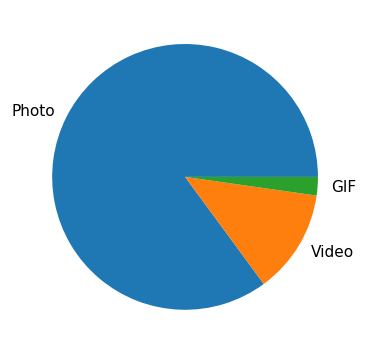

In [13]:
print(f"The amount of photos is {total_amount_of_photo}, that is {total_amount_of_photo*100/total_amount_of_media:.4f}% of all media")
print(f"The amount of videos is {total_amount_of_video}, that is {total_amount_of_video*100/total_amount_of_media:.4f}% of all media")
print(f"The amount of gifs is {total_amount_of_gif}, that is {total_amount_of_gif*100/total_amount_of_media:.4f}% of all media")
plt.pie([total_amount_of_photo, total_amount_of_video, total_amount_of_gif], labels=["Photo", "Video", "GIF"])
plt.show()

                                  0
generated_feature_n_photo          
0                          38986200
1                          10998049
2                           3123989
3                            807857
4                           1605139


Text(0, 0.5, 'Number of tweet with X photo')

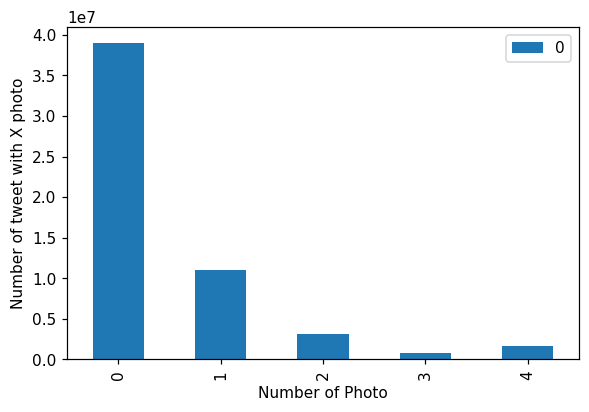

In [14]:
aggregate_result = pd.DataFrame(unique_tweet_dataframe[['generated_feature_n_photo']].groupby("generated_feature_n_photo").size())
print(aggregate_result)
plot = aggregate_result.plot(kind="bar")
plot.set_xlabel('Number of Photo')
plot.set_ylabel('Number of tweet with X photo')

                                  0
generated_feature_n_video          
0                          51640026
1                           3880784
4                               424


Text(0, 0.5, 'Number of tweet with X video')

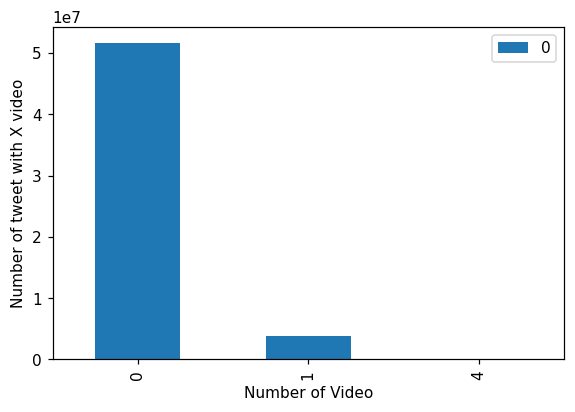

In [15]:
aggregate_result = pd.DataFrame(unique_tweet_dataframe[['generated_feature_n_video']].groupby('generated_feature_n_video').size())
print(aggregate_result)
plot = aggregate_result.plot(kind="bar")
plot.set_xlabel('Number of Video')
plot.set_ylabel('Number of tweet with X video')

                                0
generated_feature_n_gif          
0                        54832382
1                          688852


Text(0, 0.5, 'Number of tweet with X gif')

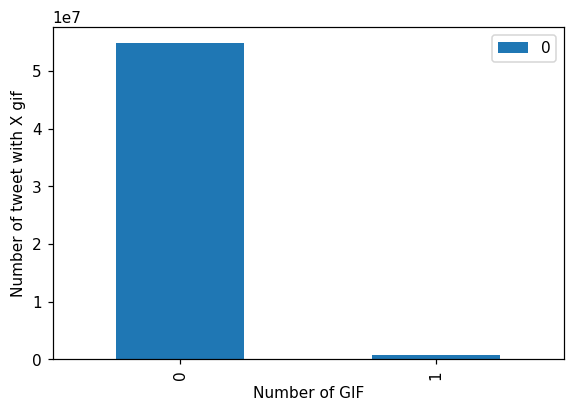

In [16]:
aggregate_result = pd.DataFrame(unique_tweet_dataframe[['generated_feature_n_gif']].groupby("generated_feature_n_gif").size())
print(aggregate_result)
plot = aggregate_result.plot(kind="bar")
plot.set_xlabel('Number of GIF')
plot.set_ylabel('Number of tweet with X gif')

                                  0
generated_feature_n_media          
0                          34416140
1                          15567685
2                           3123989
3                            807857
4                           1605563


Text(0, 0.5, 'Number of tweet with X media')

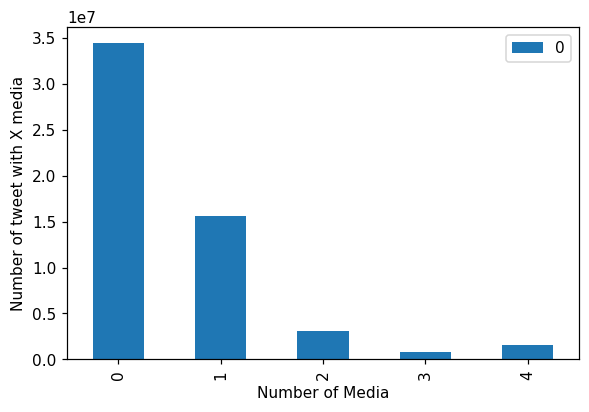

In [17]:
aggregate_result = pd.DataFrame(unique_tweet_dataframe[['generated_feature_n_media']].groupby("generated_feature_n_media").size())
print(aggregate_result)
plot = aggregate_result.plot(kind="bar")
plot.set_xlabel('Number of Media')
plot.set_ylabel('Number of tweet with X media')

## Let's see if there's a correlation between number of media and the type of engagement involved in the engagement


In [18]:
del unique_tweet_dataframe

gc.collect()

2181

In [19]:
%%time

temp = dd[
    ["raw_feature_engagement_reply_timestamp",
    "raw_feature_engagement_retweet_timestamp",
    "raw_feature_engagement_comment_timestamp",
    "raw_feature_engagement_like_timestamp"]
].notnull().compute()

Wall time: 52 s


In [20]:
df["tweet_feature_engagement_is_like"] = temp["raw_feature_engagement_like_timestamp"]
df["tweet_feature_engagement_is_retweet"] = temp["raw_feature_engagement_retweet_timestamp"]
df["tweet_feature_engagement_is_reply"] = temp["raw_feature_engagement_reply_timestamp"]
df["tweet_feature_engagement_is_comment"] = temp["raw_feature_engagement_comment_timestamp"]

del temp

In [21]:
df.head()

,raw_feature_tweet_media,generated_feature_n_photo,generated_feature_n_gif,generated_feature_n_video,mapped_feature_tweet_id,generated_feature_n_media,tweet_feature_engagement_is_like,tweet_feature_engagement_is_retweet,tweet_feature_engagement_is_reply,tweet_feature_engagement_is_comment
24664,Photo,2,0,0,37515430,2,True,False,False,False
89447,Photo,1,0,0,4460350,1,False,False,False,False
87332,Photo,0,0,0,42494194,0,True,True,False,False
22500,Photo\tPhoto\tPhoto\tPhoto,4,0,0,16993919,4,True,False,False,False
82911,None,2,0,0,8076949,2,True,False,False,False


In [22]:
df["tweet_feature_engagement_is_negative"] = ~ (
    df["tweet_feature_engagement_is_like"] 
    + df["tweet_feature_engagement_is_retweet"] 
    + df["tweet_feature_engagement_is_reply"] 
    + df["tweet_feature_engagement_is_comment"]
)

df.head(20)

C:\Users\ALEXDRUSO\Anaconda3\envs\RecSysFramework\lib\site-packages\pandas\core\computation\expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


,raw_feature_tweet_media,generated_feature_n_photo,generated_feature_n_gif,generated_feature_n_video,mapped_feature_tweet_id,generated_feature_n_media,tweet_feature_engagement_is_like,tweet_feature_engagement_is_retweet,tweet_feature_engagement_is_reply,tweet_feature_engagement_is_comment,tweet_feature_engagement_is_negative
24664,Photo,2,0,0,37515430,2,True,False,False,False,False
89447,Photo,1,0,0,4460350,1,False,False,False,False,True
87332,Photo,0,0,0,42494194,0,True,True,False,False,False
22500,Photo\tPhoto\tPhoto\tPhoto,4,0,0,16993919,4,True,False,False,False,False
82911,None,2,0,0,8076949,2,True,False,False,False,False
30919,None,0,0,0,30625902,0,False,False,False,False,True
9724,None,4,0,0,7073660,4,True,False,False,False,False
74690,Photo,0,0,0,24041394,0,False,False,False,False,True
94600,Photo,1,0,0,30479174,1,False,False,False,False,True
116294,Photo\tPhoto,0,0,0,15470516,0,False,False,False,False,True


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78599968 entries, 24664 to 26358
Data columns (total 11 columns):
 #   Column                                Dtype 
---  ------                                ----- 
 0   raw_feature_tweet_media               object
 1   generated_feature_n_photo             int64 
 2   generated_feature_n_gif               int64 
 3   generated_feature_n_video             int64 
 4   mapped_feature_tweet_id               int32 
 5   generated_feature_n_media             int64 
 6   tweet_feature_engagement_is_like      bool  
 7   tweet_feature_engagement_is_retweet   bool  
 8   tweet_feature_engagement_is_reply     bool  
 9   tweet_feature_engagement_is_comment   bool  
 10  tweet_feature_engagement_is_negative  bool  
dtypes: bool(5), int32(1), int64(4), object(1)
memory usage: 4.2+ GB


In [24]:
result = pd.DataFrame(df.groupby("generated_feature_n_media").sum())

In [25]:
result['n_engagements'] = pd.DataFrame(df.groupby("generated_feature_n_media").size())

In [26]:
result['like_ratio'] = result['tweet_feature_engagement_is_like'] / result['n_engagements']
result['retweet_ratio'] = result['tweet_feature_engagement_is_retweet'] / result['n_engagements'] 
result['reply_ratio'] = result['tweet_feature_engagement_is_reply'] / result['n_engagements'] 
result['comment_ratio'] = result['tweet_feature_engagement_is_comment'] / result['n_engagements'] 
result['negative_ratio'] = result['tweet_feature_engagement_is_negative'] / result['n_engagements']

Text(0, 0.5, 'Probability it is involved in that type of engagement')

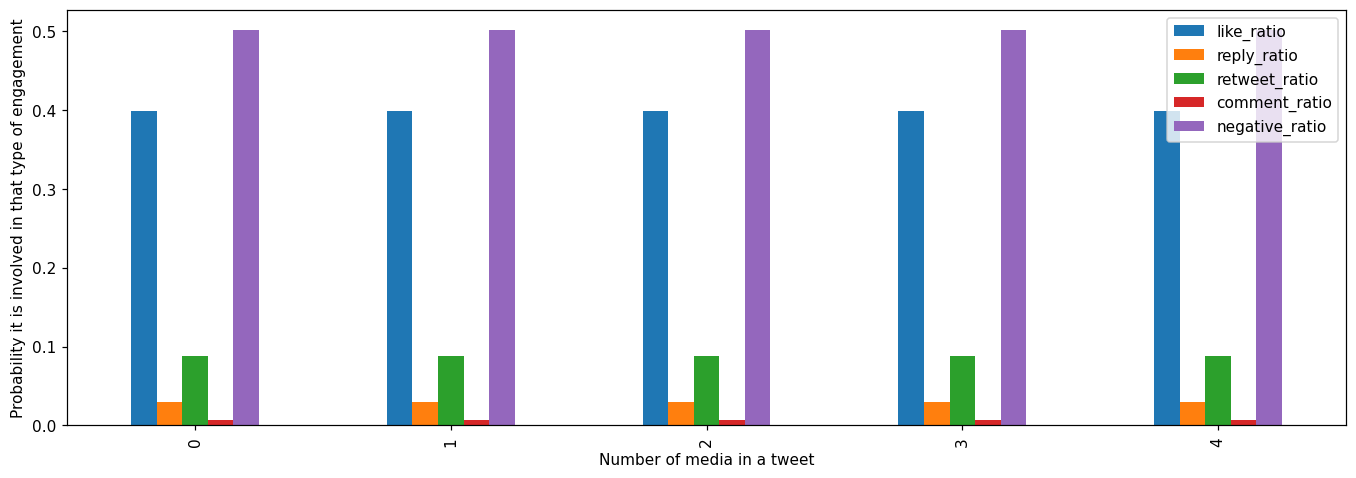

In [27]:
plt.rcParams['figure.figsize'] = [15, 5]
plot = result[[
    'like_ratio',
    'reply_ratio',
    'retweet_ratio',
    'comment_ratio',
    'negative_ratio'
]].plot(kind="bar")
plot.set_xlabel("Number of media in a tweet")
plot.set_ylabel("Probability it is involved in that type of engagement")

## Do tweets with more media receive more engagements?

In [28]:
del result

In [29]:
#find  number interactions

result = pd.DataFrame(df.groupby("generated_feature_n_media").sum())

result.head()

,generated_feature_n_photo,generated_feature_n_gif,generated_feature_n_video,mapped_feature_tweet_id,tweet_feature_engagement_is_like,tweet_feature_engagement_is_retweet,tweet_feature_engagement_is_reply,tweet_feature_engagement_is_comment,tweet_feature_engagement_is_negative
generated_feature_n_media,,,,,,,,,
0,0,0,0,1.352455e+15,19394921,4267010,1446132,345478,24406138
1,15571460,976102,5492545,6.117187e+14,8774812,1932571,652169,156256,11040088
2,8843316,0,0,1.227408e+14,1760359,386584,130910,31206,2215937
3,3431733,0,0,3.172667e+13,455771,100098,33710,8121,573064
4,9089480,0,2352,6.311431e+13,905177,199386,67495,16080,1137866


In [30]:
#find number of tweet with a certain number of media 

result['n_tweets_by_n_media'] = pd.DataFrame(df.drop(
    [
        'tweet_feature_engagement_is_like', 
        'tweet_feature_engagement_is_retweet',
        'tweet_feature_engagement_is_reply',
        'tweet_feature_engagement_is_comment',
        'tweet_feature_engagement_is_negative'
    ]
    , axis=1)\
.drop_duplicates()\
.groupby("generated_feature_n_media")\
.size()
)

result.head()

,generated_feature_n_photo,generated_feature_n_gif,generated_feature_n_video,mapped_feature_tweet_id,tweet_feature_engagement_is_like,tweet_feature_engagement_is_retweet,tweet_feature_engagement_is_reply,tweet_feature_engagement_is_comment,tweet_feature_engagement_is_negative,n_tweets_by_n_media
generated_feature_n_media,,,,,,,,,,
0,0,0,0,1.352455e+15,19394921,4267010,1446132,345478,24406138,36530702
1,15571460,976102,5492545,6.117187e+14,8774812,1932571,652169,156256,11040088,18978025
2,8843316,0,0,1.227408e+14,1760359,386584,130910,31206,2215937,4039652
3,3431733,0,0,3.172667e+13,455771,100098,33710,8121,573064,1100479
4,9089480,0,2352,6.311431e+13,905177,199386,67495,16080,1137866,2139309


In [31]:
result['like_ratio'] = result['tweet_feature_engagement_is_like'] / result['n_tweets_by_n_media']
result['retweet_ratio'] = result['tweet_feature_engagement_is_retweet'] / result['n_tweets_by_n_media'] 
result['reply_ratio'] = result['tweet_feature_engagement_is_reply'] / result['n_tweets_by_n_media'] 
result['comment_ratio'] = result['tweet_feature_engagement_is_comment'] / result['n_tweets_by_n_media'] 
result['negative_ratio'] = result['tweet_feature_engagement_is_negative'] / result['n_tweets_by_n_media']

Text(0, 0.5, 'Number of engagements per tweet')

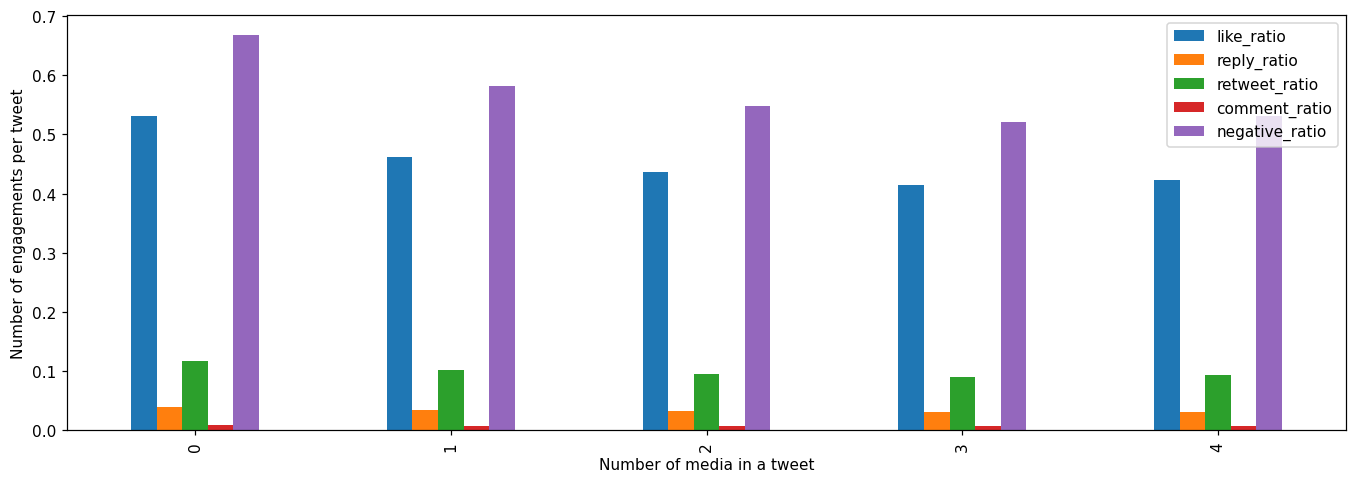

In [32]:
plt.rcParams['figure.figsize'] = [15, 5]
plot = result[[
    'like_ratio',
    'reply_ratio',
    'retweet_ratio',
    'comment_ratio',
    'negative_ratio'
]].plot(kind="bar")
plot.set_xlabel("Number of media in a tweet")
plot.set_ylabel("Number of engagements per tweet")